# Voting Classifier

In this notebook, we explore using a voting classifier to predict if PA forms will be approved. We will be using Drug, BIN, Reject Code, and flags for Tried & Failed, Contraindication, and Correct Diagnosis for prediction. First, we import the needed packages.

In [1]:
##Import packages
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [2]:
## Import classifiers
from sklearn.ensemble import ExtraTreesClassifier,VotingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier

## Import splits and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

Now, we create our train test split, making sure to stratify on PA approval. We choose the test size to be 20% of our total data, and use the same random seed in all other method notebooks. We will use the test set after choosing our final model (and not in this notebook).

In [3]:
#import cleaned CSV (no date information)
cmm_pa_clf_read = pd.read_csv("../Data/cmm_pa_clf.csv",index_col = 0)

#drop pa_approved for the predictors, only use it for target.
cmm_pa_clf_data = cmm_pa_clf_read.drop(columns = 'pa_approved').copy()
cmm_pa_clf_target = cmm_pa_clf_read['pa_approved'].copy()
X_train,X_test,y_train,y_test= train_test_split(cmm_pa_clf_data, cmm_pa_clf_target, test_size = 0.2, 
                                             random_state = 10475, shuffle = True,
                                            stratify = cmm_pa_clf_target)

## Baseline Model

Our baseline model will be predicting all claims will have PA approved, as the majority of claims are approved.

In [4]:
if y_train.value_counts(normalize=True)[1]>.5:
    print(np.round(y_train.value_counts(normalize=True)[1]*100,3),"percent of the training set has PA approved, so",
          "our baseline model will predict all PA forms are approved.")
else:
    print(np.round(y_train.value_counts(normalize=True)[1]*100,3),"percent of the training set has PA approved, so",
          "our baseline model will predict all PA forms are declined.")

73.445 percent of the training set has PA approved, so our baseline model will predict all PA forms are approved.


## Voting Classifier vs. Individual Classifiers
### Hard Voting
We use a validation set to explore the accuracy rate and roc_auc between the voting classifier (hard voting) and the individual models.


In [5]:
#create validation set
X_train_train,X_holdout,y_train_train,y_holdout= train_test_split(X_train, y_train, test_size = 0.2, 
                                             random_state = 10475, shuffle = True,
                                            stratify = y_train)

models=['Baseline','Logistic Regression','Extra Trees','Bernoulli NB','XGBoost','Voting']

#matrices to hold accuracy and ROC-AUC scores for validation set and train_train subset
cv_accs = np.zeros((len(models)))
cv_accs_train = np.zeros((len(models)))
cv_aucs = np.zeros((len(models)))
cv_aucs_train = np.zeros((len(models)))


    
#baseline performance on the train and validation set
cv_accs_train[0] = accuracy_score(y_train_train, np.ones(len(y_train_train)))
cv_aucs_train[0] = roc_auc_score(y_train_train, np.ones(len(y_train_train)))
cv_accs[0] = accuracy_score(y_holdout, np.ones(len(y_holdout)))
cv_aucs[0] = roc_auc_score(y_holdout, np.ones(len(y_holdout)))    
    
#logistic regression
logreg=LogisticRegression(C=.1)
logreg.fit(X_train_train,y_train_train)
                   
cv_accs_train[1] = accuracy_score(y_train_train, logreg.predict(X_train_train))
cv_aucs_train[1] = roc_auc_score(y_train_train, logreg.predict_proba(X_train_train)[:,1])
cv_accs[1] = accuracy_score(y_holdout, logreg.predict(X_holdout))
cv_aucs[1] = roc_auc_score(y_holdout, logreg.predict_proba(X_holdout)[:,1])
    
#extra trees
extrat=ExtraTreesClassifier(n_estimators=25,max_depth=6,random_state=10475)
extrat.fit(X_train_train,y_train_train)

cv_accs_train[2] = accuracy_score(y_train_train, extrat.predict(X_train_train))
cv_aucs_train[2] = roc_auc_score(y_train_train, extrat.predict_proba(X_train_train)[:,1])
cv_accs[2] = accuracy_score(y_holdout, extrat.predict(X_holdout))
cv_aucs[2] = roc_auc_score(y_holdout, extrat.predict_proba(X_holdout)[:,1])    
    
#bernoulliNB
bnb=BernoulliNB(alpha = 0.3, fit_prior = True)
bnb.fit(X_train_train,y_train_train)

cv_accs_train[3] = accuracy_score(y_train_train, bnb.predict(X_train_train))
cv_aucs_train[3] = roc_auc_score(y_train_train, bnb.predict_proba(X_train_train)[:,1])
cv_accs[3] = accuracy_score(y_holdout, bnb.predict(X_holdout))
cv_aucs[3] = roc_auc_score(y_holdout, bnb.predict_proba(X_holdout)[:,1])      
 
                   
#xgboost
print("Starting xgboost.")
xgbc= XGBClassifier(booster = 'gbtree',objective = 'binary:logistic',max_depth = 3,subsample = 1,
                      tree_method = 'approx', n_estimators= 90,
                      eta = 1, use_label_encoder=False,eval_metric = 'logloss',verbosity = 0)
xgbc.fit(X_train_train,y_train_train)
                   
cv_accs_train[4] = accuracy_score(y_train_train, xgbc.predict(X_train_train))
cv_aucs_train[4] = roc_auc_score(y_train_train, xgbc.predict_proba(X_train_train)[:,1])
cv_accs[4] = accuracy_score(y_holdout, xgbc.predict(X_holdout))
cv_aucs[4] = roc_auc_score(y_holdout, xgbc.predict_proba(X_holdout)[:,1])
    

#voting using above models
print("Starting Voting")
voting = VotingClassifier([('logreg', LogisticRegression(C=.1)),
                          ('extrat', ExtraTreesClassifier(n_estimators=25,max_depth=6,random_state=10475)),
                          ('bnb', BernoulliNB(alpha = 0.3, fit_prior = True)),
                          ('xgbc', XGBClassifier(booster = 'gbtree',objective = 'binary:logistic',
                                                 max_depth = 3,subsample = 1,tree_method = 'approx',
                                                 n_estimators= 90,eta = 1, use_label_encoder=False,
                                                 eval_metric = 'logloss',verbosity = 0))],
                          voting='soft')
voting.fit(X_train_train,y_train_train)
    
cv_accs_train[5] = accuracy_score(y_train_train, voting.predict(X_train_train))
cv_aucs_train[5] = roc_auc_score(y_train_train,voting.predict_proba(X_train_train)[:,1])

cv_accs[5] = accuracy_score(y_holdout, voting.predict(X_holdout))
cv_aucs[5] = roc_auc_score(y_holdout, voting.predict_proba(X_holdout)[:,1])

Starting xgboost.
Starting Voting


In [6]:
print("The accuracy scores:")
print("For training subsets:",cv_accs_train)
print("For the validation subsets:",cv_accs)
print("The ROC-AUC scores:")
print("For training subsets:",cv_aucs_train)
print("For the validation subsets:",cv_aucs)

The accuracy scores:
For training subsets: [0.73445229 0.8138378  0.81396427 0.80301455 0.81401767 0.81396427]
For the validation subsets: [0.73445229 0.81539482 0.81530488 0.80348952 0.81522619 0.81530488]
The ROC-AUC scores:
For training subsets: [0.5        0.87762182 0.87732833 0.86961119 0.87793417 0.87739804]
For the validation subsets: [0.5        0.87909757 0.87853148 0.87080284 0.87926957 0.8787649 ]


In [7]:
print("The model with the best accuracy was:",models[np.argmax(cv_accs)])
print("The model with the best ROC AUC score was:",models[np.argmax(cv_aucs)])

The model with the best accuracy was: Logistic Regression
The model with the best ROC AUC score was: XGBoost


We plot the accuracy and ROC-AUC for the train train and validation sets for each model. As the baseline performs much worse, we leave it out of this visualization, to better see the difference between the (non-baseline) models.

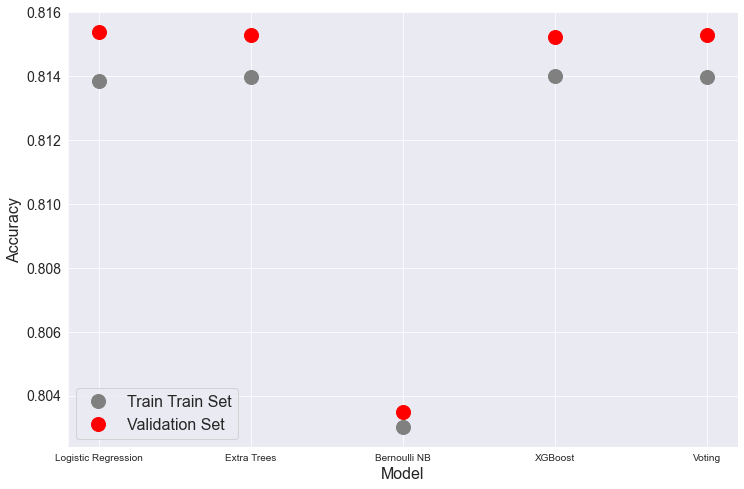

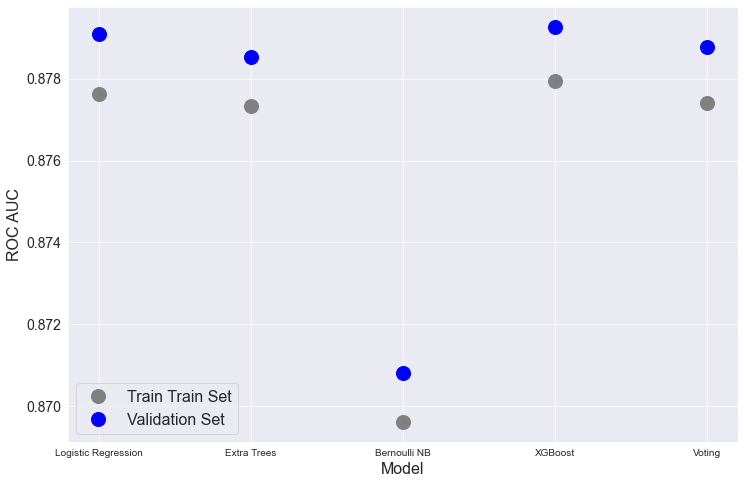

In [8]:
## this plots the average accuracy and accuracy for the CV subsets as a function of the maximum depth
plt.figure(figsize=(12,8))

#plot validation accuracy
plt.plot(range(1,len(models)),cv_accs_train[1:],'o',color='gray',label="Train Train Set",markersize=14) 
plt.plot(range(1,len(models)),cv_accs[1:],'o',color='red',label="Validation Set",markersize=14) 


plt.legend(fontsize=16)

plt.xlabel("Model", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)

plt.xticks(range(1,len(models)),models[1:], fontsize=10)
plt.yticks(fontsize=14)

plt.show()

##this plots the average ROC-AUC and ROC-AUC for the CV subsets
plt.figure(figsize=(12,8))

#plot CV ROC-AUC scores
plt.plot(range(1,len(models)),cv_aucs_train[1:],'o',color='gray',label="Train Train Set",markersize=14) 
plt.plot(range(1,len(models)),cv_aucs[1:],'o',color='blue',label="Validation Set",markersize=14) 
    

plt.legend(fontsize=16)

plt.xlabel("Model", fontsize=16)
plt.ylabel("ROC AUC", fontsize=16)

plt.xticks(range(1,len(models)),models[1:], fontsize=10)
plt.yticks(fontsize=14)

plt.show()

While our Voting Classifier performs well, it does not beat the models it uses on accuracy nor ROC-AUC. Here we see the voting model's performance on the whole train set.

In [9]:
voting = VotingClassifier([('logreg', LogisticRegression(C=.1)),
                          ('extrat', ExtraTreesClassifier(n_estimators=25,max_depth=6,random_state=10475)),
                          ('bnb', BernoulliNB(alpha = 0.3, fit_prior = True)),
                          ('xgbc', XGBClassifier(booster = 'gbtree',objective = 'binary:logistic',
                                                 max_depth = 3,subsample = 1,tree_method = 'approx',
                                                 n_estimators= 90,eta = 1, use_label_encoder=False,
                                                 eval_metric = 'logloss',verbosity = 0))],
                          voting='soft')
voting.fit(X_train,y_train)
pred=voting.predict(X_train)
predp=voting.predict_proba(X_train)[:,1]

print("For the voting model, the accuracy on the training set is",accuracy_score(y_train,pred))
print("For the voting model, the ROC-AUC on the training set is",roc_auc_score(y_train,predp))

For the voting model, the accuracy on the training set is 0.8142323949995504
For the voting model, the ROC-AUC on the training set is 0.8776623319775134
